<a href="https://colab.research.google.com/github/ktichola/ML-and-DL-to-Gravitational-waves-analysis/blob/main/nnAudio_Constant_Q_transform_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'g2net-gravitational-wave-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F23249%2F2399555%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T143132Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D32c1a8fff0f33cd2cac07bbf2e8aa1dd1a385c11946cdc9481a9bfe85579b2a706c3943a3c7e0ee21f2abca687015c81a60f8d2f2f9ed10ff5ec4b5b5fc147ef91eb7311085f3d0f6a165d63e4b36dbb7c43a1923a7c7bd055dad1ce420f7eec9eddf174a8791f23bb5e7cb598838e0b5977c8d028e2178b4eab5c9781b7c987cdcb38a640e00ec6aed36267457231edbdda7244618846b9b4388d79d8f7d4544bb308a31abd1aafdbcf91b616657603fcdcc49dc561115a400691724fee68e86681b952081c9189424fd4bd9a9b5575f33a3727d4e210465db12214df7f28a5f7b09f8f45a6af301726da9c2561ecd9a3d1baecc230699105aa4f609e3d0e7d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


This notebook shows how Constant Q-transform from waves can be calculated with usage of nnAudio package (https://github.com/KinWaiCheuk/nnAudio).

nnAudio is an audio processing toolbox using PyTorch convolutional neural network as its backend.

Have any questions or suggestions? Please comment below.

**<font color='red'>And if you liked this notebook, please upvote it!</font>**

**Changelog**
* v6 - number of processed samples can be now easily changed via num_samples variable
* v5 - added Tukey window
* v4 - added a bandpass filter (idea taken from https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/261721#1458564) + wave plots
* v3 - small markup fix :)
* v2 - changed CQT1992v2 to CQT (alias)

## Import packages

In [ ]:
!pip install -q nnAudio

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import signal
import torch
from torch.utils.data import Dataset
from nnAudio.Spectrogram import CQT # CQT is an alias of CQT1992v2

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/nnAudio/Spectrogram.py:7: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  category=Warning,


In [ ]:
num_samples = 4 # first N samples to process

## Define dataset

Let's define a dataset to work with.

In [ ]:
class G2NetDataset(Dataset):
    def __init__(self, paths, targets, use_filter=True):
        self.paths = paths
        self.targets = targets
        self.use_filter = use_filter
        if self.use_filter:
            self.bHP, self.aHP = signal.butter(8, (20, 500), btype='bandpass', fs=2048)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        waves = np.load(self.paths[index])
        waves = np.concatenate(waves, axis=0)
        if self.use_filter:
            waves *= signal.tukey(4096*3, 0.2)
            waves = signal.filtfilt(self.bHP, self.aHP, waves)
        waves = waves/np.max(waves)
        targets = self.targets[index]

        return {
            "waves": torch.tensor(waves, dtype=torch.float),
            "target": torch.tensor(targets, dtype=torch.long),
        }

## Read training labels

Now we read training labels data, and get npy paths.

In [ ]:
ROOT_DIR = '../input/g2net-gravitational-wave-detection'
df = pd.read_csv(os.path.join(ROOT_DIR, 'training_labels.csv'))
df['path'] = df['id'].apply(lambda x: f'{ROOT_DIR}/train/{x[0]}/{x[1]}/{x[2]}/{x}.npy')

## Demonstrate CQT usage

nnAudio has several implementations of CQT; we will use the recommended one - CQT1992v2 (see https://github.com/KinWaiCheuk/nnAudio/blob/master/Installation/nnAudio/Spectrogram.py for details). You can simply call CQT, since it's an alias of CQT1992v2. If you want other CQT version, you'll have to import it directly.

Let's calculate CQT for 4 first signals with and without usage of a bandpass filter (20-500Hz), and plot results!

In [ ]:
transform = CQT(sr=2048,        # sample rate
                fmin=20,        # min freq
                fmax=500,      # max freq
                hop_length=64,  # hop length
                verbose=False)

ds = G2NetDataset(df['path'], df['target'], use_filter=False)
ds_f = G2NetDataset(df['path'], df['target'], use_filter=True)

waves = []
waves_f = []
cqts = []
cqts_f = []
for i in range(num_samples):
    waves.append(ds.__getitem__(i)['waves'])
    waves_f.append(ds_f.__getitem__(i)['waves'])
    cqts.append(transform(waves[i]).squeeze())
    cqts_f.append(transform(waves_f[i]).squeeze())

### Without a filter

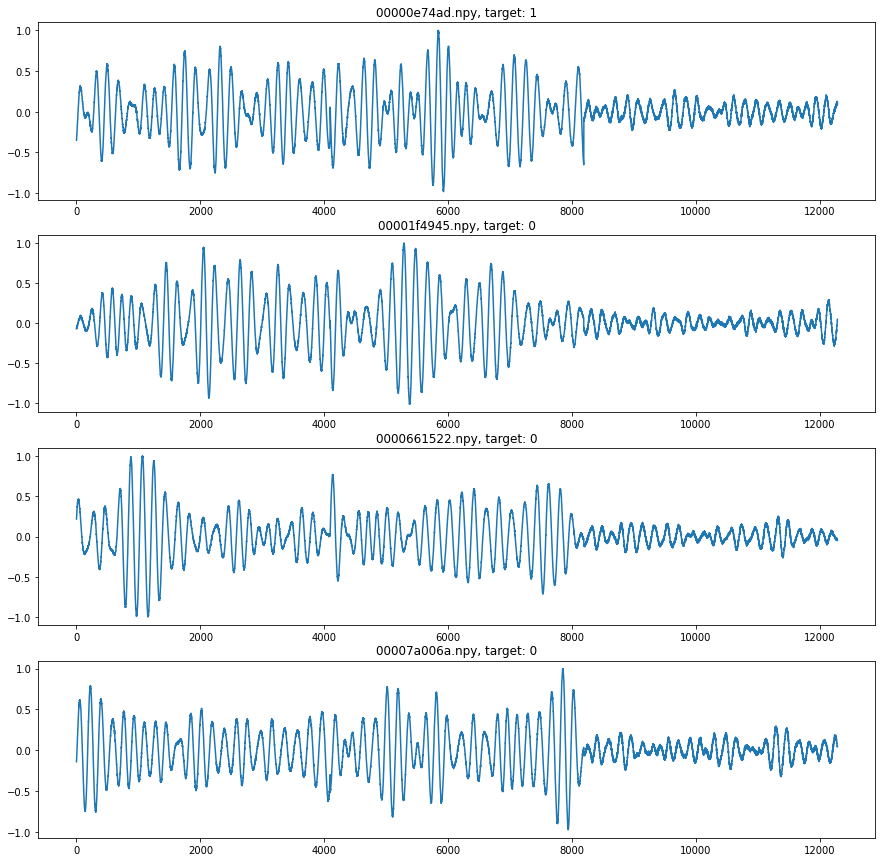

In [ ]:
fig, axs = plt.subplots(num_samples)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(num_samples):
    nid = df['id'][i]
    ntarget = df['target'][i]
    axs[i].title.set_text(f'{nid}.npy, target: {ntarget}')
    axs[i].plot(waves[i])

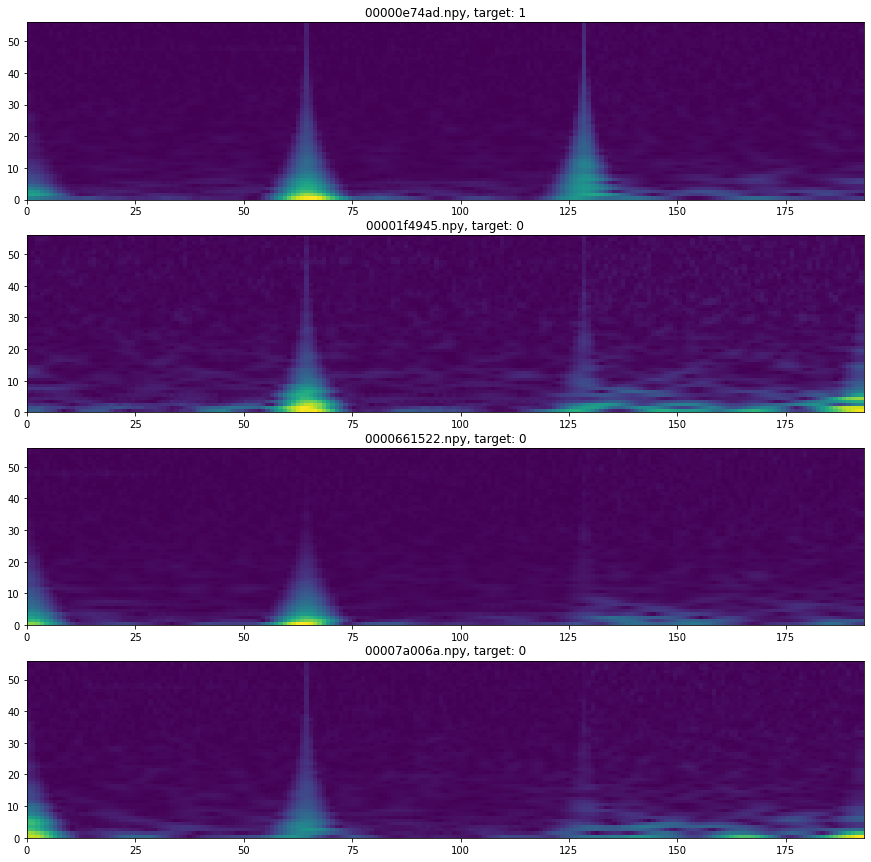

In [ ]:
fig, axs = plt.subplots(num_samples)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(num_samples):
    nid = df['id'][i]
    ntarget = df['target'][i]
    axs[i].title.set_text(f'{nid}.npy, target: {ntarget}')
    axs[i].pcolormesh(cqts[i])

### With a filter with Tukey window

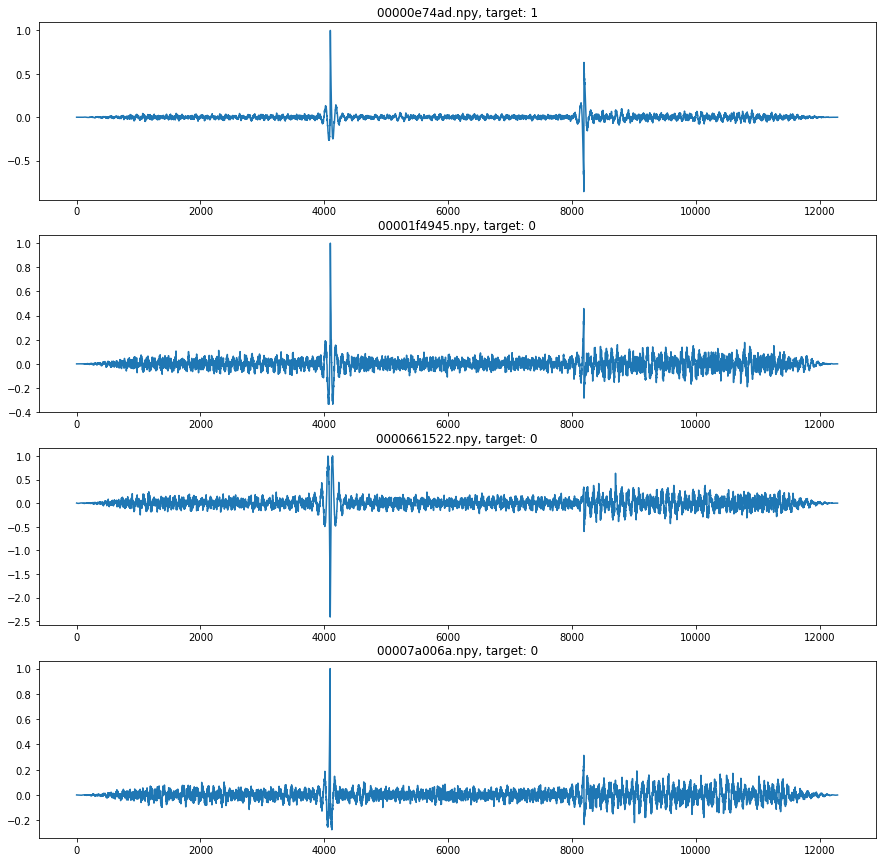

In [ ]:
fig, axs = plt.subplots(num_samples)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(num_samples):
    nid = df['id'][i]
    ntarget = df['target'][i]
    axs[i].title.set_text(f'{nid}.npy, target: {ntarget}')
    axs[i].plot(waves_f[i])

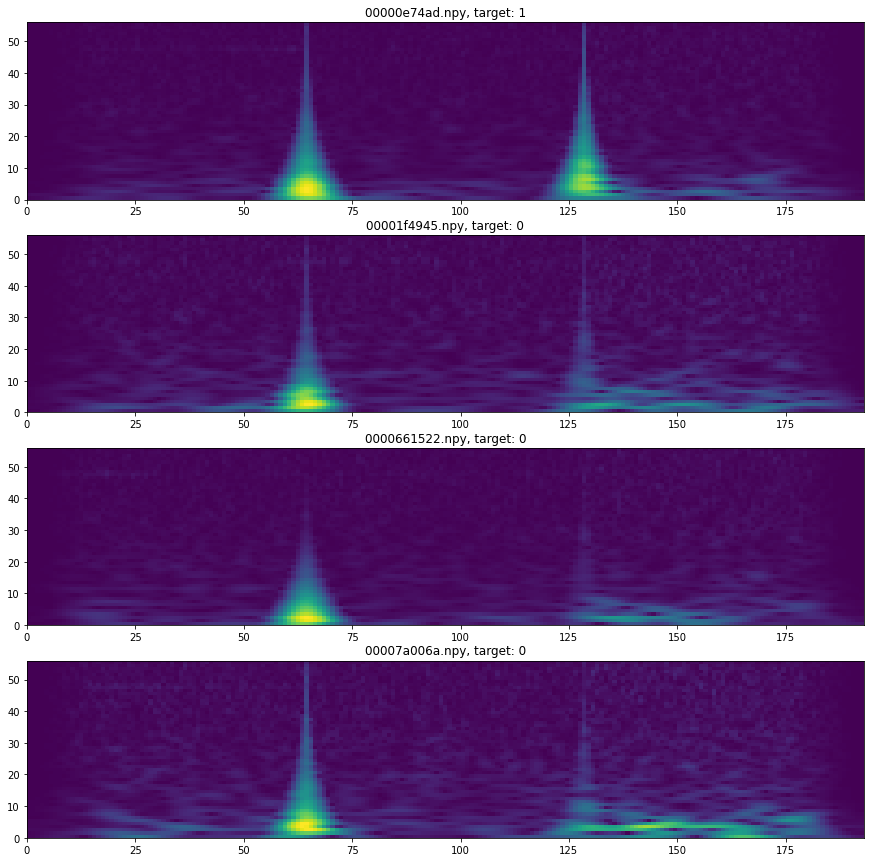

In [ ]:
fig, axs = plt.subplots(num_samples)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(num_samples):
    nid = df['id'][i]
    ntarget = df['target'][i]
    axs[i].title.set_text(f'{nid}.npy, target: {ntarget}')
    axs[i].pcolormesh(cqts_f[i])

You can use CQT() as your model block to convert waves to CQT on-the-fly.